In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wid
import progressbar

In [2]:
plt.rcParams['font.size'] = 18

# Problem Setup 

- We have a one-dimensional input space $\Lambda \subset \mathcal{R}$ 
    - we choose some nominal value $\lambda_0$ to represent a true parameter that we attempt to identify
    - we map this value to the output space and perturb it with noise from a mean-zero gaussian distribution with
    - we use an initial distribution that is gaussian
    - we propagate $N$ samples from this disribution, so the output matrix has each sample in a column. 
    
- Let $M$ denote the number of observations made of an experiment (number of trials/repetitions)
    - these are rows in our output matrix.
    
- We define our map $A: \mathcal{R} \to \mathcal{R}^M$ to repeat the values and represent multiple trials


## Exponential Decay

In [3]:
lam_0 = 0.25
def makemodel(t):
    def model(lam = np.array([[lam_0]]) ):
        QoI = lam[0,:].reshape(-1,1)*np.exp(-0.5*t)
        return QoI.T
    return model

## Harmonic Oscillator

In [4]:
lam_0 = 0.25
def makemodel(t):
    def model(lam = np.array([[lam_0]]) ):
        QoI = (0.25 - lam[0,:].reshape(-1,1))*np.cos(np.pi*t)
        return QoI.T
    return model

In [5]:
# def makemodel(t):
#     num_obs = len(t)
#     t = t.reshape(1,-1)
#     def model(lam = None):
#         if lam is None: 
#             lam = np.zeros((1,3))
#             lam[:,0] = initial_condition_0
#             lam[:,1] = decay_rate_0
#             lam[:,2] = frequency_0
#         initial_condition = lam[:,0].reshape(-1,1)
#         decay_rate = lam[:,1].reshape(-1,1)
#         frequency = lam[:,2].reshape(-1,1)
#         QoI = initial_condition*np.exp(-decay_rate*t)
#         QoI *= np.cos(np.multiply(0.5*frequency*t, 2*np.pi))
#         if QoI.shape[0] == 1:
#             return QoI.reshape(1,-1) # this allows support for simpler 1D plotting.
#         else:
#             return QoI
#     return model

# All in One

In [6]:
def solve_problem(N = 1000, 
                prior_mean = 0.0,
                prior_std = 0.25,
                M = 10, 
                data_std = 0.0125,
                lam_true = lam_0, 
                time = (1,5),
                seed=None,
                plot=True):
    
    start_time, end_time = time # unpack some parameters
    N, M = int(N), int(M) # enforce types 
    if seed is not None:
        seed = int(seed)
        np.random.seed(seed)

    t = np.linspace(start_time, end_time, M)
    ed_model = makemodel(t)
    
    def model(input_samples):
#         output_samples = A@input_samples # matrix multiplication 
        output_samples = ed_model(input_samples)
        return output_samples
    
    true_data = model(np.array([[lam_true]]))
    
    observed_data = true_data + data_std*np.random.randn(M).reshape(-1,1)
    obs_data_mean, obs_data_std = np.mean(observed_data), np.std(observed_data)
#     print('Stats on observed data:', 'mean:', obs_data_mean, 'sd:', obs_data_std)
    initial_dist = sstats.distributions.norm(loc=prior_mean, scale=prior_std)
    # initial_dist = sstats.distributions.uniform(loc=0, scale=0.5)
    
    # PLOTTING PARAMETERS
    mesh_sz = 2500

    initial_eval_mesh = np.linspace(-1, 1, mesh_sz)
    

    if plot:
        # plt.figure(figsize=(10,5))
        # plt.scatter(true_data[0],[1], c='r', s=100, label='truth')
        # plt.scatter(observed_data,np.ones(M), label='data')
        # plt.legend()
        # plt.xlim(0.15, 0.35)

        
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
        ### VISUALIZE INITIAL VS DATA OBSERVED

        axs[0,0].plot(initial_eval_mesh, initial_dist.pdf(initial_eval_mesh),c='k',lw=5)
        for i in range(M):
            sample = observed_data[i]
            temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
            axs[0,0].plot(initial_eval_mesh, temp_dist.pdf(initial_eval_mesh))
        # plt.xlim(0.15, 0.3)
        axs[0,0].set_ylim(0,2)
        axs[0,0].set_title("Initial Density and observed data with uncertainty")


    # generate input samples and map them to data space
    input_samples = initial_dist.rvs(N).reshape(1,-1)
    if plot: print('input sample shape:', input_samples.shape)

    # define map and output space
    output_samples = model(input_samples)
    if plot: print('output sample shape:', output_samples.shape)

    def loss_fun(output_samples):
#         return (1./M)*np.sum( np.power(np.divide(output_samples - observed_data, data_std), 2), axis=0)
#         return (1./np.sqrt(2*M))*np.sum( np.power(np.divide(output_samples - observed_data, data_std) , 2) - 1.0, axis=0)
        return (1./data_std)*(1./np.sqrt(M))*np.sum( output_samples - observed_data, axis=0)
    
    qoi = loss_fun(output_samples)
        
    
    
    ### Define Pushforward of Initial - choose method
    # FIT PF
#     a, l, s = sstats.distributions.gamma.fit(qoi)
#     # print(a, l, s)
#     gamma_fit = sstats.distributions.gamma(a=a,loc=l,scale=s)

#     d, l, s = sstats.distributions.chi2.fit(qoi)
#     chi2_fit = sstats.distributions.chi2(df=d,loc=l,scale=s)

    # COMPUTE ESTIMATE OF PUSHFORWARD DISTRIBUTION
    gkde_fit = sstats.gaussian_kde(qoi)
    def pf_initial_dist_PDF(x):
        # return chi2_fit.pdf(x)
        # return gamma_fit.pdf(x)
        return gkde_fit.evaluate(x)

    eval_pf_initial = pf_initial_dist_PDF(qoi)
    # print('Pushforward of Initial Distribution computed. shape:', eval_pf_initial.shape)

    # Define Observed Distribution
    obs_dist = sstats.distributions.norm()
#     obs_dist = sstats.distributions.gamma(a=M/2.0, scale=2.0/M)
    # obs_dist = sstats.distributions.chi2(df=M)
    eval_obs = obs_dist.pdf(qoi)

    
    if plot:
        num_bins = 100
        print('Loss fun min:', qoi.min(), 'Loss fun max:', qoi.max())
        # x_eval = np.linspace(-1000,1000,mesh_sz*5)
        x_eval = np.linspace(qoi.min(), qoi.max(), mesh_sz*5)
        
        #     gamma_eval = gamma_fit.pdf(x_eval)
        #     chi2_eval = chi2_fit.pdf(x_eval)
        gkde_eval = gkde_fit.evaluate(x_eval)
        axs[0,1].hist(qoi, num_bins, density=True)
    #     axs[0,1].plot(x_eval, gamma_eval, c='b', label='gamma fit')
    #     axs[0,1].plot(x_eval, chi2_eval, c='r', label='chi2 fit')
        axs[0,1].plot(x_eval, gkde_eval, '--',c='r', label='gkde fit')
        axs[0,1].plot(x_eval, obs_dist.pdf(x_eval), c='k', label = 'observed')
        axs[0,1].set_xlim(-5,5)
        axs[0,1].set_ylim(0,np.max(gkde_eval))
        axs[0,1].legend()



    ### SOLVE INVERSE PROBLEM 
    eval_initial = initial_dist.pdf(input_samples)
#     print('MIN oF PF_INPUT_EVAL:.', np.min(eval_pf_initial))

    ratio = np.divide(eval_obs, eval_pf_initial) # COMPUTE RATIO
    updated_dist = eval_initial*ratio # EVALUATE UPDATED DENSITY ON INPUT SAMPLES
    rn = np.random.rand(N)
    accepted_inds = [i for i in range(N) if ratio[i] > rn[i]]

    def eval_updated(x): # takes input sample and evaluates it through the updated density
        y = loss_fun(model(x.reshape(1,-1)))
        return  initial_dist.pdf(x)*np.divide(obs_dist.pdf(y), pf_initial_dist_PDF(y))
    
    input_samples = input_samples.ravel() # reshape 1D vectors for easier access
    updated_dist = updated_dist.ravel()
    
    
    updated_dist_eval_at_truth = eval_updated(np.array([lam_true]))
    updated_eval_mesh = np.linspace(0.2, 0.3, mesh_sz)
    updated_dist_evaluated_on_mesh = eval_updated(updated_eval_mesh) 
    
    max_input_sample_index = np.argmax(updated_dist)
    if lam_true != 0:
        rel_error_mc = np.abs( (input_samples[max_input_sample_index] - lam_true )/lam_true )
    else:
        rel_error_mc = np.abs( (input_samples[max_input_sample_index] - lam_true )/1.0 )
    
    error_mc = np.mean(np.power(output_samples[:,max_input_sample_index] - observed_data,2))
    
    
    # VISUALIZE UPDATED DENSITY
    max_eval_sample_index = np.argmax(updated_dist_evaluated_on_mesh)
    
    if lam_true != 0:
        rel_error_mesh = np.abs( (updated_eval_mesh[max_eval_sample_index] - lam_true )/lam_true )
    else:
        rel_error_mesh = np.abs( (updated_eval_mesh[max_eval_sample_index] - lam_true )/1.0 )
        print('warning: the relative error computed is actually absolute error b/c lam_true = 0.')
    
    # PLOT RESULTS AND OBSERVED DATA

    if plot:
        print('Ratio computed. Mean:', np.mean(ratio))
        print('data space predictive error: ', error_mc)
        print('parameter space  error: ', rel_error_mc)
        
        axs[1,1].vlines(lam_true, 0, updated_dist_eval_at_truth, color='b', label='true value')
        axs[1,1].plot(updated_eval_mesh, updated_dist_evaluated_on_mesh, c='k', label='updated eval, mesh: %d'%mesh_sz)
        axs[1,1].scatter(input_samples[max_input_sample_index], updated_dist[max_input_sample_index], c='b', s=250, label='Max (MC), RE:%1.2e'%rel_error_mc)
    #     axs[1,1].scatter(0.25, updated_dist_eval_at_truth, s=25, label='density val @ truth: %2.4f'%updated_dist_eval_at_truth)
        axs[1,1].scatter(updated_eval_mesh[max_eval_sample_index], updated_dist_evaluated_on_mesh[max_eval_sample_index], c='orange', s=200, label='Max (mesh), RE:%1.2e'%rel_error_mesh)

    #     axs[1,1].set_xlim(0.15, 0.35)
        axs[1,1].set_xlim(0.2,0.3)
        # axs[1,1].set_ylim(0, 200)
        axs[1,1].set_title('Updated Density evaluated')
    

    
    
    if plot:
        # axs[1,0].scatter(input_samples[0,accepted_inds], updated_dist[0,accepted_inds])
        if len(accepted_inds) > 1: # KDE of accepted samples - an estimate of updated distribution
            g = sstats.gaussian_kde(input_samples[accepted_inds])
            axs[1,0].plot(initial_eval_mesh, g.evaluate(initial_eval_mesh), 
                        label='gkde of %d accepted'%len(accepted_inds), c='b', lw=2)

#         for i in range(M-1): # plot the assumed noise distribution around each data point.
#             sample = observed_data[i]
#             temp_dist = sstats.distributions.norm(loc=sample, scale=data_std)
#             axs[1,0].plot(initial_eval_mesh, temp_dist.pdf(initial_eval_mesh), c='k', alpha=0.1)
        axs[1,0].plot(initial_eval, sstats.distributions.norm.pdf(loc=observed_data[M-1], 
                        scale=data_std, x=initial_eval), c='orange', alpha=0.75, label='observations') # OBSERVED DATA


        if len(accepted_inds) > 1: # SCATTER ACCEPTED SAMPLES
            sample = input_samples[accepted_inds[0]]
            axs[1,0].scatter(sample, g.evaluate(sample), c='red', alpha=1, label='accepted samples')
            for i in range(1,len(accepted_inds)):
                sample = input_samples[accepted_inds[i]]
                axs[1,0].scatter(sample, g.evaluate(sample), c='red', alpha=1)
            axs[1,1].scatter(input_samples[accepted_inds], updated_dist[accepted_inds], c='red', s=50, label='accepted')
        axs[1,1].scatter(input_samples, updated_dist,  c='k', s=10, label='initial samples')    


        reference_dist = sstats.distributions.norm(loc=lam_true, scale=data_std)
        ref_dist_eval = reference_dist.pdf(initial_eval_mesh)
#         axs[1,0].plot(initial_eval_mesh, ref_dist_eval, label='N(%2.4f, %2.5f$^2$)'%(lam_true, data_std), c='green', lw=3, alpha=1.0)
        axs[1,0].vlines(lam_true, 0, np.max(ref_dist_eval))
        
        if M == -1: # can't compute std on sample size of 1, this makes no sense for timeseries
            approx_dist = sstats.distributions.norm(loc=obs_data_mean, scale=obs_data_std)
            axs[1,0].plot(initial_eval_mesh, approx_dist.pdf(initial_eval_mesh), 
                label='N(%2.4f, %2.5f$^2$)'%(obs_data_mean, obs_data_std), c='purple', lw=3, alpha=1.0)
            # axs[1,0].plot(initial_eval_mesh, g.evaluate(initial_eva_meshl), 
#                 label='gkde of %d accepted'%len(accepted_inds), c='b')

#         axs[1,0].set_xlim(0.2,0.3)
    #     axs[1,0].set_xlim(0.15, 0.35)
        axs[1,0].set_title("Updated Density, observed data with uncertainty")
        axs[1,0].legend(fontsize=12)
        axs[1,1].legend(fontsize=12)
    if plot:
        plt.show()
        
    SUMMARY = {
        'N': N,
        'M': M, 
        'seed': seed, 
        'prior_mean': prior_mean,
        'prior_std': prior_std,
        'data_std': data_std,
        'lam_true': lam_true,
        'mud_val': input_samples[max_input_sample_index],
        'rel_error_mc': rel_error_mc,
        'obs_data_mean': obs_data_mean,
        'obs_data_std': obs_data_std,
        'num_accepted': len(accepted_inds),
        'time': [start_time, end_time],
        'mean_r': ratio.mean(),
        'qoi_min': qoi.min(),
        'qoi_max': qoi.max()
    }
    if not plot:
        return SUMMARY, input_samples[accepted_inds], observed_data

In [7]:
wid.interact_manual(solve_problem, 
                prior_mean=wid.FloatSlider(min=-0.25, max=0.25, step=0.05, continuous_update=False),  
                prior_std=wid.FloatSlider(value=0.25, min=0.125, max=0.5, step=0.125, readout_format='.2e', continuous_update=False),     
                data_std=wid.FloatSlider(value=0.01, min=0.0025, max=0.0125, step=0.0025, readout_format='.2e', continuous_update=False),
                N = wid.IntSlider(value=500, min=1000, max=10000, step=1000, continuous_update=False), 
                M = wid.IntSlider(value=1, min=1, max=250, continuous_update=False), 
                time = wid.FloatRangeSlider(value=(1,5), min=1, max=5, step=0.05, continuous_update=False),
                lam_true = wid.fixed(value=lam_0, continuous_update=False),
                seed=wid.IntSlider(value=12, min=1, max=21, continuous_update=False),
                plot = wid.fixed(True))


interactive(children=(IntSlider(value=1000, continuous_update=False, description='N', max=10000, min=1000, ste…

<function __main__.solve_problem>

# Make Predictions

In [8]:
def make_predictions(N = 1000, 
                prior_mean = 0.0,
                prior_std = 0.25,
                M = 10, 
                data_std = 0.001,
                lam_true = 0.5, 
                time = (1,5),
                seed=None, 
                plot=False):

    S, I, O = solve_problem(N, prior_mean, prior_std, M, data_std, lam_true, time, seed, plot)

    start_time, end_time = S['time']
    t = np.linspace(start_time, end_time, S['M'])
    tt = np.linspace(0, 10, 1000)
    model = makemodel(tt)
    u_acc = model(I.reshape(1,-1))
    obs_data = O
    plt.figure(figsize=(20,10))

    dd = np.mean(u_acc, axis=1)
    plt.plot(tt, dd, c='k', alpha=1, lw=5, label='Mean Predicted Signal')

    for i in range(len(I)):
        d = u_acc[:,i]
        if i==1:
            plt.plot(tt, d, c='b', alpha=0.25, lw=1, label='Accepted Samples')
        else:
            plt.plot(tt, d, c='b', alpha=0.05, lw=1)

    plt.scatter(t, obs_data, marker='o', c='r', s=50, alpha=1, label='Observed Data')
    plt.plot(tt, model(np.array(S['mud_val']).reshape(-1,1)), c='green', lw=3, label='MUD prediction')
    plt.plot(tt, model(), ls=':', c='k', lw=3, label='true signal')

    plt.ylabel('Height', fontsize=18)
    plt.xlabel('Time (s)', fontsize=18)
    plt.title('Recovered Signal based on Accepted Samples', fontsize=28)
    plt.legend(fontsize=18, loc='upper left')
    plt.xlim([0,5+.05])
    plt.ylim([-0.05,0.05])
    # plt.hlines(np.mean(I),0,5)
    # plt.savefig('recovered{}.png'.format(problem.upper()))
    plt.legend()
    plt.show()
    
    return None

wid.interact_manual(make_predictions, 
                prior_mean=wid.FloatSlider(min=-0.25, max=0.25, step=0.05, continuous_update=False),  
                prior_std=wid.FloatSlider(value=0.25, min=0.125, max=0.5, step=0.125, readout_format='.2e', continuous_update=False),     
                data_std=wid.FloatSlider(value=0.01, min=0.0025, max=0.05, step=0.0025, readout_format='.2e', continuous_update=False),
                N = wid.IntSlider(value=500, min=500, max=10000, step=1000, continuous_update=False), 
                M = wid.IntSlider(value=1, min=1, max=50, continuous_update=False), 
                time = wid.FloatRangeSlider(value=(1,5), min=1, max=5, step=0.05, continuous_update=False),
                lam_true = wid.fixed(value=lam_0, continuous_update=False),
                seed=wid.fixed(None),  
#                 seed=wid.IntSlider(value=12, min=1, max=21, continuous_update=False),
                plot = wid.fixed(False))


interactive(children=(IntSlider(value=500, continuous_update=False, description='N', max=10000, min=500, step=…

<function __main__.make_predictions>

## Conduct Experiments

In [9]:
def init_data_vec():
    DATA = {'M': [],
     'N': [],
     'data_std': [],
     'lam_true': [],
     'mean_r': [],
     'qoi_max': [],
     'qoi_min': [],
     'num_accepted': [],
     'obs_data_mean': [],
     'obs_data_std': [],
     'prior_mean': [],
     'prior_std': [],
     'rel_error_mc': [],
     'mud_val': [],
     'time': [],
     'seed': []}
    return DATA

def append_summary(SUMMARY, DATA):
    for k in SUMMARY.keys():
        DATA[k].append(SUMMARY[k])
    

In [23]:
N_ = 1000
# N_list = [50*2**n for n in range(8)]
data_std_ = 0.01
# M_list = [2,3,4,5,6,7,8,9, *np.arange(1,21)*5 ]
M_list = [5, 10, 25, 50, 100, 200, 400]
num_repeats = 10 # (number of random seeds tried)
lam_true = 0.25
prior_mean = 0
prior_std = 0.5
# data_std = np.round([0.001*2**n for n in np.linspace(0,np.log2(100),5)],12).ravel() 
seed_list = np.random.randint(2,10000,num_repeats) 
assert len(np.unique(seed_list)) == len(seed_list) # ensure no repetitions

# ax = plt.subplot(1,1,1)
DDD = {}
for seed_ in progressbar.progressbar(seed_list):
    DD = init_data_vec()
    for M_ in M_list:
        SMRY = solve_problem(time = (1.4,4.35), N=N_, M=M_, seed=seed_, data_std=data_std_, lam_true=lam_true, prior_mean=prior_mean, prior_std=prior_std, plot=False)
        append_summary(SMRY[0], DD)
#     print(, DD['rel_error_mc'])
    DDD[str(seed_)] = DD
print('Done running.')

100% (10 of 10) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


Done running.


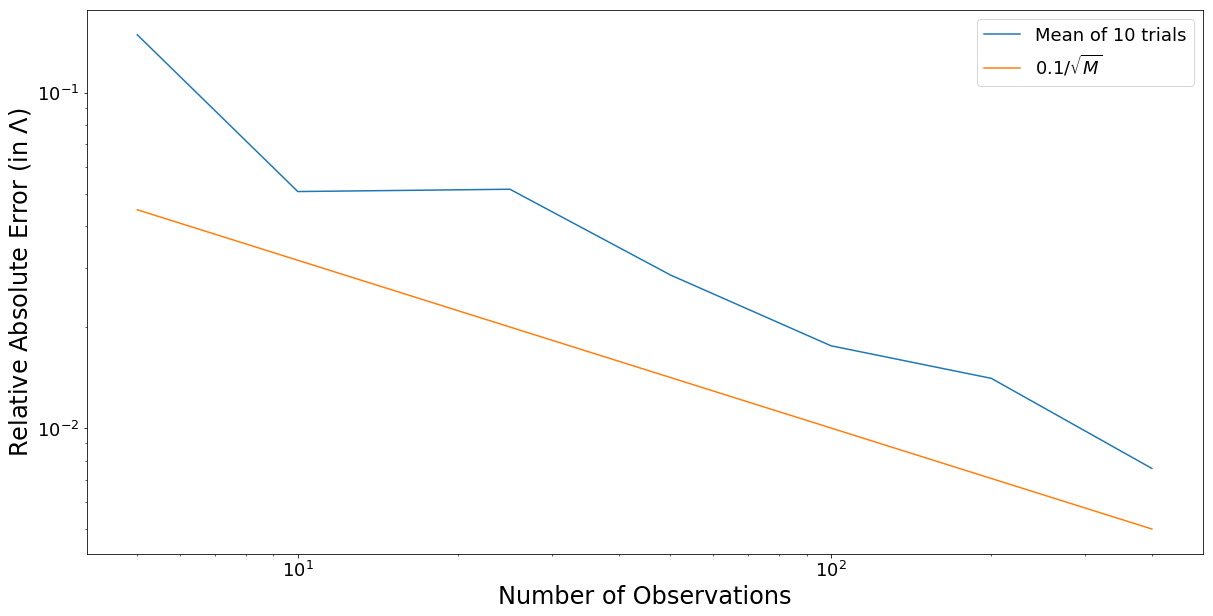

In [24]:
plt.figure(figsize=(20,10))
temp_val = np.zeros(len(M_list))
for seed_ in seed_list:
    temp_val += DDD[str(seed_)]['rel_error_mc']
#     plt.semilogy(DDD[str(seed_)]['M'], DDD[str(seed_)]['rel_error_mc'], color='k', alpha=0.5)
plt.loglog(M_list,temp_val/len(seed_list), label='Mean of %d trials'%(len(seed_list)) )
plt.loglog(M_list, 0.1/np.sqrt(np.array(M_list)), label='$0.1/ \sqrt{M}$')
# plt.ylim([1E-1, 2])
plt.ylabel('Relative Absolute Error (in $\Lambda$)', fontsize=24)
plt.xlabel('Number of Observations', fontsize=24)
plt.legend()
plt.show()